<a href="https://colab.research.google.com/github/chelynl/Machine_Learning/blob/main/16_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Artificial Neural Networks (ANN)**
- Can fall under all 3 categories (supervised, unsupervised, reinforcement learning)
- **Supervised**
 - CNNs classifying images in imagenet
- **Unsupervised**
 - Boltzmann Machines, AutoEncoders, GANs, DC-GANS, VAE, SOMs, etc.
- **Reinforcement learning**
 - Deep Convolutional Q-Learning that plays videogames from pixel input, AlphaGO, etc. (deep reinforcement learning, "AI")

In [ ]:
# load dependencies
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf

In [ ]:
# see tf version
tf.__version__

'2.5.0'

## Data Preprocessing

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/chelynl/ML_notes/main/deep_learning/Churn_Modelling.csv?token=AMGO4MC3JY4W7WHLIVTAEQLA5R6CC')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# See dimensions
df.shape

(10000, 14)

In [ ]:
# No missing data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# Define target and inputs
X = df.iloc[:, 3:-1]
y = df.iloc[:, -1]

In [ ]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [ ]:
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

**Encode categorical data**

- Get binary values for the `'Gender'` column by using `OrdinalEncoder()` since `LabelEncoder()` is not compatible for features and it's usually used for binary targets.
- Get dummy values for the `'Geography'` column using `OneHotEncoder()` since there are three countries (levels) with no ordering.

After encoding, scale features to prevent features from producing activations of very different sizes that can cause unstable training behavior.

In [ ]:
# Create encoding pipeline
encoder = make_column_transformer(
    # label encode "gender" col
    (OrdinalEncoder(), ['Gender']),
    # one-hot encode "geography" col
    (OneHotEncoder(), ['Geography']),
    remainder='passthrough'
)

# Encode features
X = encoder.fit_transform(X)
# Scale features
ss = StandardScaler()
X = ss.fit_transform(X)

# See number of units to use for NN
input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Input shape: [12]


## Model Building

- NNs can be thought of as compositions of logistic regressions
- Intercept is called "bias"
- Input units are associated with weights
 - **Weights** are determined by an optimization algorithm that minimizes the loss function
 - **Optimization** algorithms: stochastic gradient descent (Adams, etc.)
 - **Loss** functions: MAE, MSE, Huber for regression and cross-entropy for classification
- Special layers:
 - **Dropout** = get ensemble of layers to prevent overfitting and get better predictions
 - **BatchNorm** = can help correct slow/unstable training by normalizing each batch
- NNs stops when training loss reaches close to 0 (potential for overfitting) and last epoch is used
- You can stop training prematurely via **early stopping** to prevent overfitting, which will stop training once validation loss starts to increase (training stops before last epoch)

### Terminology
- Loss function
 - calculated at every instance/epoch (multiple times for a single training set)
- Cost function
 - calculated as an average of loss functions (once for a single training set)
- Activation function
 - allow NNs to learn complex nonlinear patterns
 - breaks the linearity between the output neurons and input neurons
 - ex/ rectifier activation

### How to decide number of hidden layers?
 - more layers can give higher accuracy but also potential for overfitting
 - more layers = higher capacity (easier to learn nonlinear patterns)
 - use intuition, experience, and parameter tuning to find the best number (no rule of thumb)


In [ ]:
# Instantiate ANN
ann = tf.keras.models.Sequential() # Sequential() is used to initialize NN as a sequence of layers

# Add input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu')) # Dense() is used to add a layer of neurons to NN

# Add second input layer
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

# Add output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Model Training

Before training, weights are randomly initialized with values close to 0. Then, over the course of epochs, the weights are updated via SGD in the direction that decreases the most loss error (cost function) between predictions and the targets.

### Training Process of Each Iteration (Epoch)
1. Forward Propagation: inputs are forward propagated inside the NN (at the end returns the prediction).
2. Compare prediction to the target and compute the loss error between them.
3. That loss error is back-propagated inside the NN.
4. Through SGD, the weights are updated in the directions that reduce the most loss error (loss error is a cost function of the weights).
5. New weights are assigned to inputs and repeat iteration to make new prediction. Continue process until the loss error stops reducing (early stopping) or until training reaches the last epoch.

In [ ]:
# Compile the ANN
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fit ANN to training data
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
250/250 [==============================] - 1s 1ms/step - loss: 0.7586 - accuracy: 0.4921
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.5995 - accuracy: 0.7952
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4965 - accuracy: 0.7962
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4496 - accuracy: 0.8027
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4275 - accuracy: 0.8124
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4130 - accuracy: 0.8227
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 0.4011 - accuracy: 0.8303
Epoch 8/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3899 - accuracy: 0.8366
Epoch 9/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3798 - accuracy: 0.8406
Epoch 10/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3712 - accura

### Classification for multiple categories
If you have a non-binary target (more than 2 levels), use dummy variables for the target and `activation="softmax"` and `loss="categorical_crossentropy"`.

### Regression
- Change loss function to MAE, MSE, etc.
- Remove accuracy metric
- Import KerasRegressor

## Make predictions and evaluate model

Use our ANN model to predict if the customer with the following informations will leave the bank:

- Geography: France
- Credit Score: 600
- Gender: Male
- Age: 40 years old
- Tenure: 3 years
- Balance: \$60000
- Number of Products: 2
- Does this customer have a credit card ? Yes
- Is this customer an Active Member: Yes
- Estimated Salary: \$50000

So, should we say goodbye to that customer ?

In [ ]:
# Get prediction

"""
Feature values should be in a double square brackets because the "predict" 
method always expects a 2D array as the format of its inputs. 

Also, one-hot encoding was done manually prior to scaling.
"""
# Use transform instead of fit_transform to avoid information leakage from test set
print(ann.predict(ss.transform([[1, 0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])) > 0.5)

[[False]]


The ANN model predicts that this customer stays in the bank!



In [ ]:
# Get test predictions
y_pred = ann.predict(X_test) # class probabilities
y_pred = (y_pred > 0.5) # class labels

print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)), 1))

[[0 0]
 [0 1]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [ ]:
# See confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1514   81]
 [ 198  207]]


0.8605

### How to improve ANN accuracy?
Play around with different parameters (changing number of hidden layers and/or units per layer), change formulas, and normalize data.

***

# Convolutional Neural Networks

CNNs can be used for image processing and text comprehension.

**Purpose of Feature Maps**<br>
We are building feature maps with each convolutional filter, meaning we are making features that help us classify the object. The example shown in the Intuition Lecture is like a one-dimensional edge detection filter. That is one feature map. So we want our model to "activate" in a feature map only where there is an edge. We will have several feature maps like this which when all put together will help us identify the object. This is helped by removing the black or the negative values.

**Purpose of ReLU**<br>
The biggest reason why we use ReLU is because we want to increase the non-linearity in our image. And ReLU acts as a function which breaks up linearity. And the reason why we want to break up linearity in our
network is because images themselves are highly non-linear. Indeed they have a lot of non-linear elements like the transitions between pixels.

In [5]:
# Load dependencies
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [6]:
# See tf version
tf.__version__

'2.5.0'

## Data Preprocessing

**Preprocessing the Training Set**

(need to transform the training set ONLY to prevent overfitting called *Image Augmentation* so that CNN does not overlearn existing images)

Transformations can include geometrical changes, zooms, rotations on images

In [7]:
# Create object that will apply series of transformations to modify training images
train_datagen = ImageDataGenerator(rescale=1./255, # applies feature scaling to each pixel
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Get transformed training set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML concepts/Deep Learning/CNN dataset/training_set',
                                                 target_size = (64, 64), # final size of images when they are fed into CNN (larger images = slower training)
                                                 batch_size = 32, # how many images we want in each batch
                                                 class_mode = 'binary') # binary or categorical

Found 8000 images belonging to 2 classes.


**Preprocess the Test Set**

In [8]:
# Do NOT apply same transformation as training and just perform feature scaling 
test_datagen = ImageDataGenerator(rescale = 1./255)

# Get scaled test set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ML concepts/Deep Learning/CNN dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.


## Building the CNN

In [9]:
# Instantiate CNN model object
cnn = tf.keras.models.Sequential()

In [10]:
# 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

In [11]:
# 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

Why does Max-Pooling consider only 4 values to take a maximum from and not 2 or 8 values? Also in convolution how is the feature detector formed?

Because a maximum is taken from a spot on the image which is represented by a 2x2 square on our image. Therefore it covers 4 pixels.

In [12]:
# Add second layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [13]:
# Flattening
cnn.add(tf.keras.layers.Flatten())

After flattening, are we going to get one long vector for all pooled layers or a vector for each pooled layer?

It will be one long vector gathering all the pooled layers.

In [14]:
# Full connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

In [15]:
# Output layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

**How much images are required to train a good model? Is there any rule of thumb for this decision?**

10,000 is a good number. No rule of thumbs, just the more you have, the better chance you’ll have to get a
good accuracy.

**Could you please explain the numbers 0, 1, 2, 3 and 4 in the feature maps?**

When the 3x3 feature detector is covering one part of the input image, it gets:
- 0 if there is no 1 in common between the 3x3 subtable of the input image and the 3x3 feature detector
- 1 if there is one 1 in common between the 3x3 subtable of the input image and the 3x3 feature detector
- 2 if there is two 1 in common between the 3x3 subtable of the input image and the 3x3 feature detector
- 3 if there is three 1 in common between the 3x3 subtable of the input image and the 3x3 feature detector
- 4 if there is four 1 in common between the 3x3 subtable of the input image and the 3x3 feature detector

**Could you please recap the forward propagation of the input images happening inside the CNN by describing in a few words the classes we use in Python?**

Sure, here is the process with the essential descriptions of the classes used:
- Sequential is first used to specify we introduce a sequence of layers, as opposed to a computational graph.
- Convolution2D is then used to add the convolutional layer.
- MaxPooling2D is then used to apply Max Pooling to the input images.
- Flatten is then used to flatten the pooled images.
- Dense is used to add the output layer with softmax.

## Training the CNN

In [16]:
# Compile CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
# Train CNN on training set and evaluate test set
cnn.fit(x = training_set, validation_data = test_set, epochs = 25)

Epoch 1/25
250/250 [==============================] - 2294s 9s/step - loss: 0.6548 - accuracy: 0.6086 - val_loss: 0.7486 - val_accuracy: 0.5850
Epoch 2/25
250/250 [==============================] - 84s 337ms/step - loss: 0.5919 - accuracy: 0.6925 - val_loss: 0.5542 - val_accuracy: 0.7145
Epoch 3/25
250/250 [==============================] - 84s 335ms/step - loss: 0.5577 - accuracy: 0.7067 - val_loss: 0.5188 - val_accuracy: 0.7460
Epoch 4/25
250/250 [==============================] - 84s 337ms/step - loss: 0.5218 - accuracy: 0.7336 - val_loss: 0.4956 - val_accuracy: 0.7560
Epoch 5/25
250/250 [==============================] - 85s 340ms/step - loss: 0.5056 - accuracy: 0.7451 - val_loss: 0.5169 - val_accuracy: 0.7550
Epoch 6/25
250/250 [==============================] - 85s 338ms/step - loss: 0.4733 - accuracy: 0.7738 - val_loss: 0.4668 - val_accuracy: 0.7805
Epoch 7/25
250/250 [==============================] - 85s 341ms/step - loss: 0.4553 - accuracy: 0.7846 - val_loss: 0.4939 - val_acc

## Make Prediction

**How to make a single prediction whether a specific picture contains a cat or a dog?**

Inside the dataset folder you need to create a separate additional folder (let’s call it "single_prediction")
containing the image (let’s call it "cat_or_dog.jpg") you want to predict and run the following code:

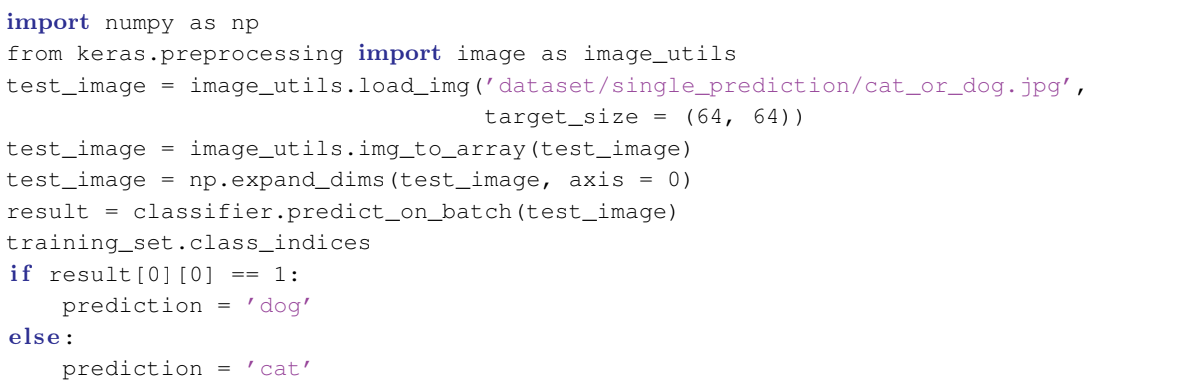

In [22]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/Colab Notebooks/ML concepts/Deep Learning/CNN dataset/single_prediction/cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'

In [23]:
print(prediction) # correct

dog


In [26]:
test_image = image.load_img('/content/drive/MyDrive/Colab Notebooks/ML concepts/Deep Learning/CNN dataset/single_prediction/cat_or_dog_2.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'dog'
else:
  prediction = 'cat'

In [27]:
print(prediction) # incorrect

dog
